#Per ottenere i vettori del vocabolario
https://github.com/vijayaiitk/NLP-text-classification-model/issues/1

Prendi le parole più simili
https://aneesha.medium.com/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
https://stackoverflow.com/questions/37818426/get-most-similar-words-given-the-vector-of-the-word-not-the-word-itself
https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html

In [1]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [236]:
import pandas as pd
import nltk
import numpy as np
import string

from mi_helper import *
from sklearn.pipeline import Pipeline

from numpy import array 

In [237]:
from gensim.models import Word2Vec

In [238]:
from nltk import sent_tokenize
from nltk import pos_tag

In [239]:
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [297]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t")
dataset.tail()

rating       date   variation  \
3145       5  30-Jul-18  Black  Dot   
3146       5  30-Jul-18  Black  Dot   
3147       5  30-Jul-18  Black  Dot   
3148       5  30-Jul-18  White  Dot   
3149       4  29-Jul-18  Black  Dot   

                                       verified_reviews  feedback  
3145  Perfect for kids, adults and everyone in betwe...         1  
3146  Listening to music, searching locations, check...         1  
3147  I do love these things, i have them running my...         1  
3148  Only complaint I have is that the sound qualit...         1  
3149                                               Good         1

In [242]:
# dataset.drop(dataset[dataset.rating == 3].index, inplace=True) #droppa recensioni con 3-4 stelle
# dataset.drop(dataset[dataset.rating == 4].index, inplace=True)

In [126]:
# CREAZIONE DI UN SAMPLE DATASET BILANCIATO
# prende le prime n recensioni positive di lunghezza maggiore, dove n è il numero di recensioni negative
def create_balanced_dataset(dataset):
    """Bilancia il dataset uniformando il numero di recensioni negative e positive. Prende in input il dataset"""
    reviews_1 = list(dataset[dataset["feedback"] == 1]["verified_reviews"])
    reviews_0 = list(dataset[dataset["feedback"] == 0]["verified_reviews"])
    reviews_1.sort(key=len, reverse = True)
    sample_1 = reviews_1[:len(reviews_0)]
    verified_reviews_sample = []
    feedback_sample = []
    verified_reviews_sample.extend(sample_1)
    verified_reviews_sample.extend(reviews_0)
    feedback_sample.extend([1 for i in range(len(sample_1))])
    feedback_sample.extend([0 for i in range(len(reviews_0))])
    dataset = pd.DataFrame({"verified_reviews":verified_reviews_sample, "feedback": feedback_sample})
    print(dataset["feedback"].value_counts())
    return dataset


dataset = create_balanced_dataset(dataset)

1    257
0    257
Name: feedback, dtype: int64


In [298]:
corpus =''
for review in dataset["verified_reviews"]:
    corpus+=" " + review
sentences = sent_tokenize(corpus)
sentences

[' Love my Echo!',
 'Loved it!',
 'Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.',
 'I like being able to turn lights on and off while away from home.',
 'I have had a lot of fun with this thing.',
 'My 4 yr old learns about dinosaurs, i control the lights and play games like categories.',
 'Has nice sound when playing music as well.',
 'Music I received the echo as a gift.',
 'I needed another Bluetooth or something to play music easily accessible, and found this smart speaker.',
 'Can’t wait to see what else it can do.',
 'Without having a cellphone, I cannot use many of her features.',
 'I have an iPad but do not see that of any use.',
 'It IS a great alarm.',
 'If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.',
 'She does not seem to be very smartbon politics yet.',
 "I t

In [299]:
def get_wordnet_pos(treebank_tag):
    """
    return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
    """
    if treebank_tag.startswith('J'):
        return "a"
    elif treebank_tag.startswith('V'):
        return "v"
    elif treebank_tag.startswith('N'):
        return "n"
    elif treebank_tag.startswith('R'):
        return "r"
    else:
        return "n"
        
custom_stopwords = ["echo", "alexa", "dot", "amzon", "prime", "2nd", "generation", "1st", "3rd", "4th", "5th"]
pos_list = ["JJ", "JJR", "JJS", "RB", "RBR", "RBS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]

def tokenize_list_of_text(list_of_text, custom_stopwords = [], pos_filter = True, pos_list = []):
    """Tokenizza tutte le recensioni, pulisce da stopwords, elimina token <= 2 caratteri e lemmatizza. Ritorna la colonna delle recensioni."""

    tokenizer = nltk.tokenize.TweetTokenizer()
    lemmatizer = nltk.WordNetLemmatizer()
    tokenized_reviews = []
    sent_tokenized_reviews = []
    for review in list_of_text: #pulisce le recensioni
        clean_text = ""
        tokens = tokenizer.tokenize(review)
        tokens = [w.lower() for w in tokens]
        tokens_pos = pos_tag(tokens)
        if pos_filter:
            clean_tokens = [(w, get_wordnet_pos(pos)) for w, pos in tokens_pos if w not in string.punctuation and len(w)>2 and w not in stopwords.words("english") and w not in custom_stopwords and pos in pos_list]
        else:
            clean_tokens = [(w, get_wordnet_pos(pos)) for w, pos in tokens_pos if w not in string.punctuation and len(w)>2 and w not in stopwords.words("english") and w not in custom_stopwords]
        lemmatized_tokens = [lemmatizer.lemmatize(w, pos) for w, pos in clean_tokens]
        sent_tokenized_reviews.append(lemmatized_tokens)
        for t in lemmatized_tokens:
            clean_text += " " + t
        tokenized_reviews.append(clean_text)

    return tokenized_reviews,  sent_tokenized_reviews

In [300]:
new_text, new_sent_tok = tokenize_list_of_text(sentences, custom_stopwords, True, pos_list)
# contengono una lista di tutte le frasi pre processate, nella prima variabile in stringa, nella seconda in tokens 

In [301]:
new_sent_tok

[['love'],
 ['love'],
 ['sometimes', 'play', 'answer', 'correctly', 'say', 'get', 'wrong', 'answer'],
 ['able', 'turn', 'away'],
 [],
 ['old', 'control', 'play'],
 ['nice', 'play', 'well'],
 ['receive'],
 ['need', 'play', 'easily', 'accessible', 'find', 'smart'],
 ['see', 'else'],
 ['cannot', 'use', 'many'],
 ['see'],
 ['great'],
 ['almost', 'hear', 'enough', 'keep', 'fun', 'ask', 'random', 'hear'],
 ['seem', 'smartbon', 'yet'],
 ['think', 'purchase'],
 ['work', 'get'],
 ['really', 'feature', 'offer', 'specifily', 'play', 'control'],
 ['look', 'great', 'love'],
 ['listen'],
 ['get'],
 ['great'],
 ['send', 'old', 'talk', 'constantly'],
 ['love'],
 ['learn', 'know', 'eveyday'],
 ['still', 'figure', 'work', 'far', 'easy', 'use', 'understand'],
 ['make',
  'laugh',
  'purchase',
  'knee',
  'give',
  'try',
  'come',
  'get',
  'around',
  'fast',
  'did.she',
  'enjoy',
  'little',
  'big',
  'play',
  'cook'],
 [],
 ['expect'],
 ['love'],
 ['really', 'happy'],
 ['great', 'easy', 'set'],


In [302]:
#window = numero di token, min_num = frequenza minima dei token, sg = traing algorithm - skip-gram, negative = negative example
#aggiorna soltato un numero k di pesi nella rete per le parole più informative 
w2v_model = Word2Vec(new_sent_tok, vector_size=300, window=10, min_count=3, sg=1, epochs=20, negative=10)

In [307]:
w2v_model.wv.most_similar(['bad'], topn = 20) #Nearest neighboor --> high cosine similarity

[('allow', 0.9789900779724121),
 ('realize', 0.9786818623542786),
 ('open', 0.9767785668373108),
 ('black', 0.9724215865135193),
 ('unfortunately', 0.9720938801765442),
 ('fix', 0.9718883037567139),
 ('replace', 0.9712086915969849),
 ('constantly', 0.9696069955825806),
 ('wrong', 0.9694714546203613),
 ('unlimited', 0.9694195985794067),
 ('randomly', 0.9690718054771423),
 ('write', 0.9686042070388794),
 ('hope', 0.9682209491729736),
 ('want', 0.9678888320922852),
 ('move', 0.9675630331039429),
 ('let', 0.9666264653205872),
 ('front', 0.9662529230117798),
 ('leave', 0.9661731719970703),
 ('spanish', 0.9657928943634033),
 ("i'll", 0.9650610089302063)]

In [309]:
w2v_model.wv.vectors[0] # contiene i vettori

array([ 1.00996390e-01,  1.36501968e-01,  2.90058204e-03,  6.71889260e-02,
       -6.92045316e-02, -1.41130924e-01,  1.08855791e-01,  3.28949630e-01,
       -2.72930693e-02, -7.58144185e-02,  1.38667569e-01, -3.30875330e-02,
       -8.32928717e-02,  7.44784623e-02, -7.70681351e-02, -1.04551084e-01,
        1.05742954e-01,  1.42576788e-02,  7.49563947e-02, -1.46510050e-01,
        1.40669504e-02, -1.03682987e-01,  1.17507204e-01,  8.60411078e-02,
        1.13766149e-01, -4.19030339e-02, -1.31146535e-01, -3.61146824e-03,
        1.51803214e-02, -1.38614535e-01,  3.41713987e-02,  4.79252711e-02,
        6.03592172e-02,  4.19196561e-02,  4.80189547e-02,  1.16087846e-01,
        1.47937909e-01, -1.58067212e-01,  5.23891533e-03, -5.02607673e-02,
       -9.23375711e-02,  2.20851861e-02,  5.51836565e-02, -1.05656140e-01,
        3.43307182e-02,  1.03140391e-01,  5.77698797e-02,  7.29965046e-02,
        2.08040122e-02,  7.82211870e-02,  5.64721823e-02, -5.35174534e-02,
       -8.89490396e-02,  

The structure is called “KeyedVectors” and is essentially a mapping between keys and vectors. Each vector is identified by its lookup key, most often a short string token, so this is usually a mapping between {str => 1D numpy array}
https://radimrehurek.com/gensim/models/keyedvectors.html

Other useful internals in Gensim 4.0+ include model.wv.index_to_key, a plain list of the key (word) in each index position, and model.wv.key_to_index, a plain dict mapping keys (words) to their index positions.

In [310]:
w2v_model.wv.key_to_index

{'love': 0,
 'great': 1,
 'use': 2,
 'get': 3,
 'work': 4,
 'good': 5,
 'easy': 6,
 'set': 7,
 'buy': 8,
 'play': 9,
 'well': 10,
 'still': 11,
 'really': 12,
 'new': 13,
 'much': 14,
 'smart': 15,
 'also': 16,
 'make': 17,
 'ask': 18,
 'learn': 19,
 'want': 20,
 'far': 21,
 'need': 22,
 'think': 23,
 'sound': 24,
 'even': 25,
 'connect': 26,
 'say': 27,
 'listen': 28,
 'turn': 29,
 'know': 30,
 'go': 31,
 'try': 32,
 'little': 33,
 'tell': 34,
 'purchase': 35,
 'able': 36,
 'see': 37,
 'amazon': 38,
 'enjoy': 39,
 'find': 40,
 'add': 41,
 'nice': 42,
 'come': 43,
 'give': 44,
 'many': 45,
 'like': 46,
 'look': 47,
 'hear': 48,
 'take': 49,
 'small': 50,
 'best': 51,
 'first': 52,
 'expect': 53,
 'happy': 54,
 'watch': 55,
 'control': 56,
 'wish': 57,
 'awesome': 58,
 'pretty': 59,
 'sure': 60,
 'seem': 61,
 'old': 62,
 'keep': 63,
 'talk': 64,
 'perfect': 65,
 "i'm": 66,
 'call': 67,
 'big': 68,
 'amazing': 69,
 'definitely': 70,
 'yet': 71,
 'start': 72,
 'recommend': 73,
 'cool': 74

In [311]:
w2v = dict(zip(w2v_model.wv.index_to_key, w2v_model.wv.vectors))
w2v

{'love': array([ 1.00996390e-01,  1.36501968e-01,  2.90058204e-03,  6.71889260e-02,
        -6.92045316e-02, -1.41130924e-01,  1.08855791e-01,  3.28949630e-01,
        -2.72930693e-02, -7.58144185e-02,  1.38667569e-01, -3.30875330e-02,
        -8.32928717e-02,  7.44784623e-02, -7.70681351e-02, -1.04551084e-01,
         1.05742954e-01,  1.42576788e-02,  7.49563947e-02, -1.46510050e-01,
         1.40669504e-02, -1.03682987e-01,  1.17507204e-01,  8.60411078e-02,
         1.13766149e-01, -4.19030339e-02, -1.31146535e-01, -3.61146824e-03,
         1.51803214e-02, -1.38614535e-01,  3.41713987e-02,  4.79252711e-02,
         6.03592172e-02,  4.19196561e-02,  4.80189547e-02,  1.16087846e-01,
         1.47937909e-01, -1.58067212e-01,  5.23891533e-03, -5.02607673e-02,
        -9.23375711e-02,  2.20851861e-02,  5.51836565e-02, -1.05656140e-01,
         3.43307182e-02,  1.03140391e-01,  5.77698797e-02,  7.29965046e-02,
         2.08040122e-02,  7.82211870e-02,  5.64721823e-02, -5.35174534e-02,
    

In [312]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statistics 
#from plotnine import *
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import cosine_similarity

from kneed import KneeLocator

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer


#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [313]:
vectors=w2v_model.wv.vectors
len(vectors)

718

In [314]:
words = w2v_model.wv.index_to_key
len(words)

718

In [315]:
sse_list = []
silhouette_list = []
for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
    kmeans.fit(vectors)
    sse_list.append( kmeans.inertia_ )
    silhouette_list.append(silhouette_score(vectors,kmeans.labels_))

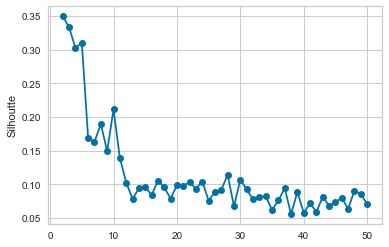

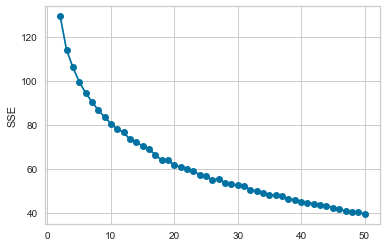

In [316]:
plt.plot(range(2, len(silhouette_list)+2), silhouette_list, marker='o')
plt.ylabel('Silhoutte')
plt.show()
plt.plot(range(2, len(sse_list)+2), sse_list, marker='o')
plt.ylabel('SSE')
plt.show()

In [342]:
kmeans = KMeans(n_clusters=10, n_init=10, max_iter=300)
kmeans.fit(vectors)

KMeans(n_clusters=10)

In [343]:
centers=kmeans.cluster_centers_ # centroidi
labels=kmeans.labels_ # clusters labels
np.unique(labels, return_counts=True) 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 10,  54,  11, 212,   4, 292,  16,  28,  74,  17], dtype=int64))

In [336]:
len(centers[0]) # lunghezza del vettore di un centroide

300

In [337]:
for i in centers:
    print(w2v_model.wv.most_similar(i, topn=20))
    print("####################################################")

[('neat', 0.9948877692222595), ('inexpensive', 0.9933905005455017), ('miss', 0.9927621483802795), ('bring', 0.9921152591705322), ('overall', 0.9919984936714172), ('various', 0.9917583465576172), ('anticipate', 0.9911312460899353), ('satisfied', 0.9910846948623657), ('intuitive', 0.9905028939247131), ('stream', 0.9897600412368774), ('interact', 0.9890469312667847), ('subscribe', 0.9885412454605103), ('advertised', 0.9877393841743469), ('straight', 0.9873665571212769), ('additional', 0.9862841367721558), ('surprise', 0.9859825968742371), ('sit', 0.9857154488563538), ('disappointed', 0.9851016998291016), ("let's", 0.9846800565719604), ('regular', 0.9844275712966919)]
####################################################
[('along', 0.9955074787139893), ('drop', 0.9933563470840454), ('regret', 0.992760181427002), ('willing', 0.9925840497016907), ('laugh', 0.9924977421760559), ('felt', 0.9918550848960876), ('seamlessly', 0.9908421635627747), ('integrate', 0.9907790422439575), ('unlimited', 0.

In [338]:
df = pd.DataFrame()

In [339]:
print(len(w2v["love"]))
print(len(centers[0])) # to check if the vectors have the same length

300
300


In [340]:
from numpy import dot
from numpy.linalg import norm

words = []
labels = []
cos = []
for w, label in zip(w2v, kmeans.labels_):
    words.append(w)
    labels.append(label)
    # this calculates the similarity bewtween centroids and all the words in their clusters
    cos_sim = dot(w2v[w], centers[label])/(norm(w2v[w])*norm(centers[label])) # cosine similarity formula (dot(a, b)/norm(a)*norm(b))
    cos.append(cos_sim)
    
df["word"] = words
df["labels"] = labels
df["cos"] = cos

df[df["labels"] == 0].sort_values(by = "cos", ascending = False).head(20) # shows the most similar words to that cluster

word  labels       cos
512          neat       0  0.994888
480   inexpensive       0  0.993391
146          miss       0  0.992762
223         bring       0  0.992115
158       overall       0  0.991998
317       various       0  0.991758
361    anticipate       0  0.991131
262     satisfied       0  0.991085
288     intuitive       0  0.990503
176        stream       0  0.989760
310      interact       0  0.989047
625     subscribe       0  0.988541
199    advertised       0  0.987739
487      straight       0  0.987366
195    additional       0  0.986284
140  disappointed       0  0.985102
183       regular       0  0.984428
332      navigate       0  0.984259
58        awesome       0  0.984045
304        fairly       0  0.983577

In [341]:
print(df[df["labels"] == 0].sort_values(by = "cos", ascending = False).to_markdown())

|     | word         |   labels |      cos |
|----:|:-------------|---------:|---------:|
| 512 | neat         |        0 | 0.994888 |
| 480 | inexpensive  |        0 | 0.993391 |
| 146 | miss         |        0 | 0.992762 |
| 223 | bring        |        0 | 0.992115 |
| 158 | overall      |        0 | 0.991998 |
| 317 | various      |        0 | 0.991758 |
| 361 | anticipate   |        0 | 0.991131 |
| 262 | satisfied    |        0 | 0.991085 |
| 288 | intuitive    |        0 | 0.990503 |
| 176 | stream       |        0 | 0.98976  |
| 310 | interact     |        0 | 0.989047 |
| 625 | subscribe    |        0 | 0.988541 |
| 199 | advertised   |        0 | 0.987739 |
| 487 | straight     |        0 | 0.987366 |
| 195 | additional   |        0 | 0.986284 |
| 140 | disappointed |        0 | 0.985102 |
| 183 | regular      |        0 | 0.984428 |
| 332 | navigate     |        0 | 0.984259 |
|  58 | awesome      |        0 | 0.984045 |
| 304 | fairly       |        0 | 0.983577 |
| 690 | ph

In [325]:
from sklearn.manifold import TSNE

In [326]:
tsne = TSNE(3, learning_rate="auto", metric="cosine")
tokens_list = []
for vec in w2v_model.wv.vectors:
    tokens_list.append(vec)

In [327]:
new_val = tsne.fit_transform(np.array(tokens_list))

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



In [328]:
df["x"] = [x[0] for x in new_val]
df["y"] = [x[1] for x in new_val]
df["z"] = [x[2] for x in new_val]

In [329]:
print(df[df["labels"] == 3].sort_values(by = "cos", ascending = False).to_markdown())

| word   | labels   | cos   | x   | y   | z   |
|--------|----------|-------|-----|-----|-----|


In [330]:
import seaborn as sns

<AxesSubplot:xlabel='x', ylabel='y'>

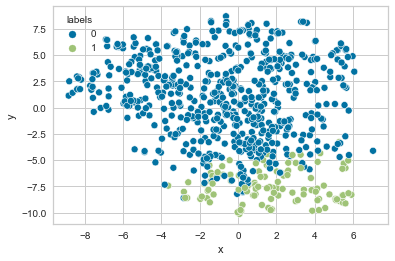

In [331]:
sns.scatterplot(data = df, x = "x", y = "y", hue = "labels")

In [332]:
import plotly_express as px

In [333]:
px.scatter_3d(data_frame = df, x = "x", y = "y", z = "z", color = [str(x) for x in df["labels"]], hover_name = "word")